In [1]:
import torch
import gzip
import shutil
import os

# 数据准备

## 数据解压

In [2]:
data_folder = "../data"

for file_name in os.listdir(data_folder):
    if file_name.endswith(".gz"):
        file_path = os.path.join(data_folder, file_name)
        out_path = file_path.replace(".gz", "")  # 解压后的文件路径

        # 解压文件
        with gzip.open(file_path, 'rb') as in_file:
            with open(out_path, 'wb') as out_file:
                shutil.copyfileobj(in_file, out_file)

In [35]:
import numpy as np


def load_images(file_path):
    """ 载入图片数据 """
    with open(file_path, 'rb') as f:
        f.read(16)  # 根据MNIST数据集格式，跳过元数据
        data = np.frombuffer(f.read(), dtype=np.uint8)
        data = data.reshape(-1, 28, 28)  # 每张图片为 28x28
    return data


def load_labels(file_path):
    """ 载入标签数据 """
    with open(file_path, 'rb') as f:
        f.read(8)  # 根据MNIST数据集格式，跳过元数据
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

## 读取用于训练&测试的图片&标签数据

In [36]:
train_images = load_images(data_folder + "/train-images-idx3-ubyte")
train_labels = load_labels(data_folder + "/train-labels-idx1-ubyte")
test_images = load_images(data_folder + "/t10k-images-idx3-ubyte")
test_labels = load_labels(data_folder + "/t10k-labels-idx1-ubyte")

可视化数据集看看：

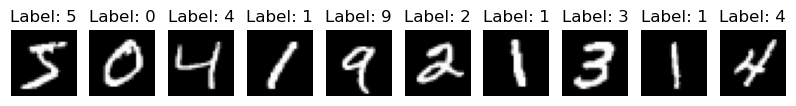

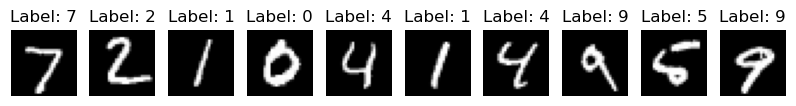

In [37]:
import matplotlib.pyplot as plt


def visualize(images, labels, num_samples=10):
    plt.figure(figsize=(10, 2))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()


# 可视化训练集的前10张图像
visualize(train_images, train_labels)

# 可视化测试集的前10张图像
visualize(test_images, test_labels)

## 数据预处理：为后续输入MLP做准备

把数据放到tensor中

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_images_tensor = torch.tensor(train_images, dtype=torch.float32, device=device)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long, device=device)
test_images_tensor = torch.tensor(test_images, dtype=torch.float32, device=device)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long, device=device)

将图片数据展平并归一化

In [39]:
train_images_tensor =  train_images_tensor.flatten(start_dim=1) / 255.0
test_images_tensor = test_images_tensor.flatten(start_dim=1) / 255.0

In [45]:
len(train_images_tensor)

60000

实现Dataset、DataLoader类来包装数据

In [ ]:
# from torch.utils.data import TensorDataset, DataLoader

# train_set = TensorDataset(train_images_tensor, train_labels_tensor)
# test_set = TensorDataset(test_images_tensor, test_labels_tensor)

# train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
# test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

In [57]:
class MyDataset:
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, id):
        return self.images[id], self.labels[id]
    
class MyDataLoader:
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.ids = np.arange(len(dataset))  # 索引列表
        self.cur_id = 0

    def __iter__(self):
        self.cur_id = 0  # 重置索引
        if self.shuffle:
            np.random.shuffle(self.ids)  # 打乱索引
        return self
    
    def __next__(self):
        if self.cur_id >= len(self.dataset):
            raise StopIteration
        
        # 获取一个batch的索引
        batch_ids = self.ids[self.cur_id : self.cur_id + self.batch_size]
        
        # 获取一个batch的对应数据
        batch_data = [self.dataset[i] for i in batch_ids]
        
        # 返回一个batch的图片和标签
        images, labels = zip(*batch_data)
        return images, labels


In [59]:
train_set = MyDataset(train_images_tensor, train_labels_tensor)
test_set = MyDataset(test_images_tensor, test_labels_tensor)

train_loader = MyDataLoader(train_set, batch_size=64, shuffle=True)
test_loader = MyDataLoader(test_set, batch_size=64, shuffle=False)

# 模型实现

In [60]:
import torch.nn as nn
import torch.nn.functional as F


实现线性层、激活函数、损失函数等组件

In [ ]:
class MyLinear(nn.Module):
    """ 线性变换层
    
    Args:
        input_size (int): 输入特征的数量
        output_size (int): 输出特征的数量
        
    Examples:
        >>> m = nn.Linear(20, 30)
        >>> input = torch.randn(128, 20)
        >>> output = m(input)
        >>> print(output.size())
        torch.Size([128, 30])
    """
    def __init__(self, input_size, output_size):
        super(MyLinear, self).__init__()

        # 正态随机初始化权重和偏置
        self.weight = torch.randn(output_size, input_size, requires_grad=True)
        self.bias = torch.randn(output_size, requires_grad=True)

    def forward(self, x):
        # 线性变换：Y = X * W^T + b
        return torch.mm(x, self.weight.T) + self.bias

In [ ]:
def relu(x):
    return torch.maximum(x, torch.tensor(0.0, device=x.device))


def softmax(x):
    exp_x = torch.exp(x)
    return exp_x / exp_x.sum(dim=1, keepdim=True)


def one_hot(labels, n):
    """ 给共分为n类的标签进行独热编码 """
    t = torch.zeros(len(labels), n)
    t[torch.arange(len(labels)), labels] = 1
    return t


def cross_entropy(predictions, truths):
    targets = one_hot(truths, len(predictions))
    return -torch.sum(targets * torch.log(predictions)).mean()

实现一个包含单隐藏层的前馈神经网络

In [69]:
class MLP(nn.Module):
    """ 包含单隐藏层的前馈神经网络 """
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = MyLinear(input_size, hidden_size)
        self.fc2 = MyLinear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = relu(x)  # 用relu作为激活函数
        x = self.fc2(x)
        x = softmax(x)
        return x

训练函数

In [ ]:
def train_loop(
    model, 
    n_epochs,
    train_loader,
    test_loader,
    loss_fn,
    optimizer
):
    pass